# Prediction based on Future Dates

## Feature engineering

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read data
df = pd.read_excel('sales_data.xlsx')
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


### Quick analysis

In [3]:
# Total number of records
print(f"Total records: {len(df)}")

Total records: 1000


In [4]:
df.nunique()

Transaction ID      1000
Date                 345
Customer ID         1000
Gender                 2
Age                   47
Product Category       3
Quantity               4
Price per Unit         5
Total Amount          18
dtype: int64

**Observation:** <br>
This shows that all the Transaction IDs and Customer IDs are unique. Thus, can't be used as features.

In [5]:
# Group by date and sum if needed
daily_sales = df.groupby('Date')['Total Amount'].sum().reset_index()

# Add Weekday and Weekend info
daily_sales['Weekday'] = daily_sales['Date'].dt.weekday
daily_sales['IsWeekend'] = daily_sales['Weekday'].isin([5, 6])

# Compute average sales
avg_weekday_sales = daily_sales.loc[~daily_sales['IsWeekend'], 'Total Amount'].mean()
avg_weekend_sales = daily_sales.loc[daily_sales['IsWeekend'], 'Total Amount'].mean()

print(f"Average Weekday Sales: {avg_weekday_sales:.2f}")
print(f"Average Weekend Sales: {avg_weekend_sales:.2f}")

Average Weekday Sales: 1305.68
Average Weekend Sales: 1360.54


**Observation:** <br>
The average of sales during weekend(2 days) is almost same as weekday(5 days). This defines that weekend the customer shops more. Thus, a strong feature to include.

### Detect Outlier and clip to max or min

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load or use existing df
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df = df.sort_values('Date')

# Make sure 'Total Amount' is numeric
df['Total Amount'] = pd.to_numeric(df['Total Amount'], errors='coerce')

# Calculate Z-scores
mean = df['Total Amount'].mean()
std = df['Total Amount'].std()
df['Z_Score'] = (df['Total Amount'] - mean) / std

# Define outliers
z_threshold = 2
df['IsOutlierZ'] = df['Z_Score'].abs() > z_threshold

# Print how many outliers detected
num_outliers = df['IsOutlierZ'].sum()
print(f"Number of outliers detected using Z-score (|z| > {z_threshold}): {num_outliers}")

Number of outliers detected using Z-score (|z| > 2): 49


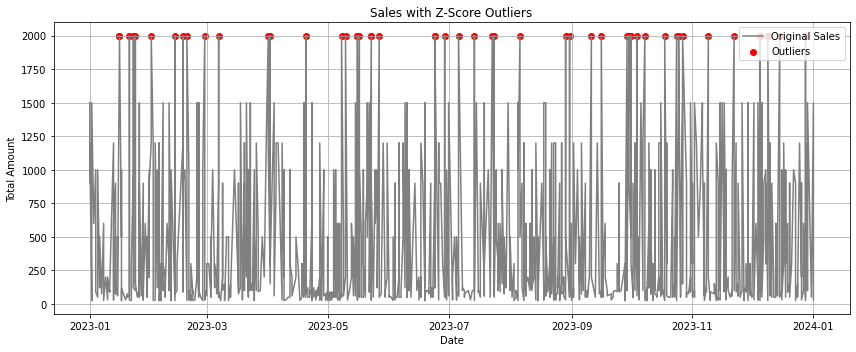

In [7]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Total Amount'], label="Original Sales", color='gray')
plt.scatter(df['Date'][df['IsOutlierZ']], df['Total Amount'][df['IsOutlierZ']], color='red', label='Outliers')
plt.title("Sales with Z-Score Outliers")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Find bounds from non-outliers
non_outliers = df[~df['IsOutlierZ']]['Total Amount']
min_valid = non_outliers.min()
max_valid = non_outliers.max()

# Replace outliers
df['AdjustedTotalAmount'] = df.apply(
    lambda row: max_valid if row['Z_Score'] > z_threshold 
    else min_valid if row['Z_Score'] < -z_threshold 
    else row['Total Amount'],
    axis=1
)

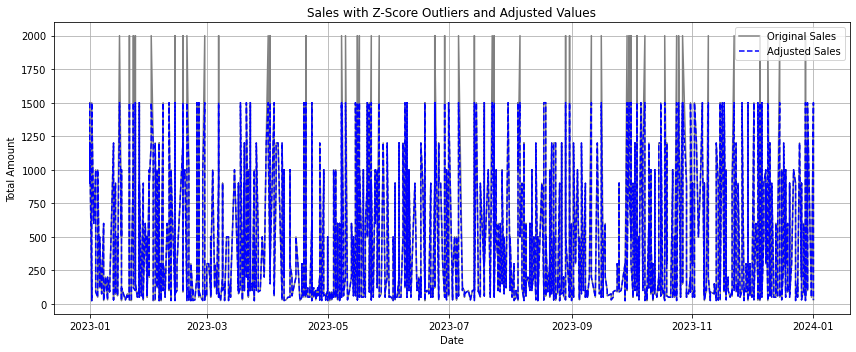

In [9]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Total Amount'], label="Original Sales", color='gray')
plt.plot(df['Date'], df['AdjustedTotalAmount'], label="Adjusted Sales", color='blue', linestyle='--')
plt.title("Sales with Z-Score Outliers and Adjusted Values")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Drop 'Z_Score' and 'Is_Outlier_Z' columns
df.drop(columns=['Z_Score', 'IsOutlierZ'], inplace=True)

In [11]:
df

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,AdjustedTotalAmount
521,522,2023-01-01,CUST522,Male,46,Beauty,3,500,1500,1500
179,180,2023-01-01,CUST180,Male,41,Clothing,3,300,900,900
558,559,2023-01-01,CUST559,Female,40,Clothing,4,300,1200,1200
302,303,2023-01-02,CUST303,Male,19,Electronics,3,30,90,90
978,979,2023-01-02,CUST979,Female,19,Beauty,1,25,25,25
...,...,...,...,...,...,...,...,...,...,...
232,233,2023-12-29,CUST233,Female,51,Beauty,2,300,600,600
804,805,2023-12-29,CUST805,Female,30,Beauty,3,500,1500,1500
856,857,2023-12-31,CUST857,Male,60,Electronics,2,25,50,50
210,211,2024-01-01,CUST211,Male,42,Beauty,3,500,1500,1500


## Modelling

### Model 1 - Sales prediction based on product category

This modelling is done to predict the total sales for any future date provided based on the product category. Three algorithms RandomForest, GradientBoost and XGBoost are trained and compared.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create new DataFrame with selected and engineered features
processed_df = pd.DataFrame({
    'Product Category': df['Product Category'],
    'Day': df['Date'].dt.day,
    'Month': df['Date'].dt.month,
    'Weekday': df['Date'].dt.weekday,
    'isWeekend': df['Date'].dt.weekday.isin([5, 6]).astype(int),
    'isAfter25': (df['Date'].dt.day > 25).astype(int),
    'LogTotalAmount': np.log1p(df['AdjustedTotalAmount'])
})

# Define Features and target
X = processed_df[['Product Category', 'Day', 'Month', 'Weekday', 'isWeekend', 'isAfter25']]
y = processed_df['LogTotalAmount']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
processed_df.head()

,Product Category,Day,Month,Weekday,isWeekend,isAfter25,LogTotalAmount
521,Beauty,1,1,6,1,0,7.313887
179,Clothing,1,1,6,1,0,6.803505
558,Clothing,1,1,6,1,0,7.090910
302,Electronics,2,1,0,0,0,4.510860
978,Beauty,2,1,0,0,0,3.258097


In [14]:
# Define categorical and numerical features
cat_features = ['Product Category']
num_features = ['Day', 'Month', 'Weekday', 'isWeekend', 'isAfter25']

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_transformer, cat_features),
    ('num', num_transformer, num_features)
])

In [15]:
# Define models with hypertune parameters
models = {
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'regressor__n_estimators': [2000, 3000, 4000],
        'regressor__max_depth': [7, 9, 11]
    }),
    'XGBoost': (XGBRegressor(random_state=42, verbosity=0), {
        'regressor__n_estimators': [2000, 3000, 4000],
        'regressor__max_depth': [7, 9, 11],
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1]
    }),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {
        'regressor__n_estimators': [2000, 3000, 4000],
        'regressor__max_depth': [7, 9, 11],
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1]
    })
}

### Train Models

In [16]:
# Train
print("Training.........")
results = {}
best_model = None
best_mae = float('inf')

for name, (model, param_grid) in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_est = grid.best_estimator_
    y_pred_log = best_est.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    results[name] = (y_pred, mae, rmse)
    if mae < best_mae:
        best_model = name
        best_mae = mae
        best_rmse = rmse
        best_grid_est = grid.best_estimator_
        
        # Save best model
        joblib.dump(grid, "./models/category_sales_model.pkl")

Training.........


In [17]:
# Print best model
print(f"\nBest Model: {best_model}\nMAE: {best_mae:.2f}, RMSE: {best_rmse:.2f}")


Best Model: XGBoost
MAE: 336.53, RMSE: 535.24


In [18]:
best_grid_est

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Product Category']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Day', 'Month', 'Weekday',


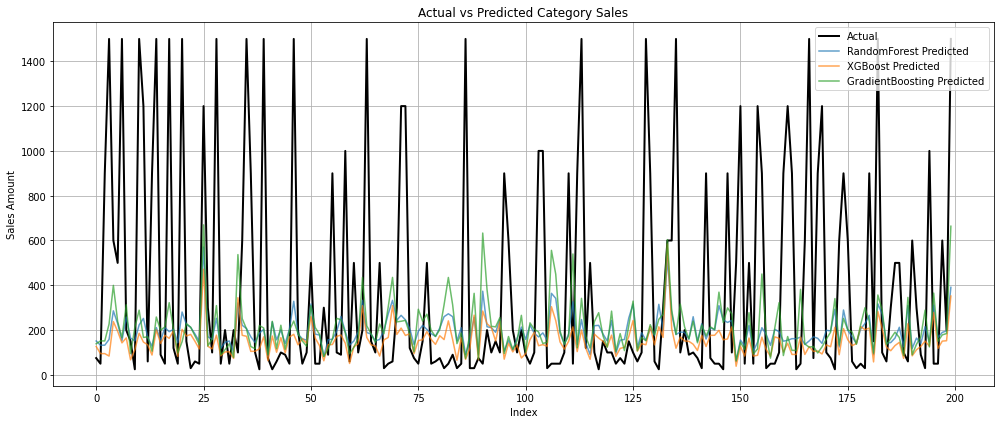

In [19]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_true.reset_index(drop=True), label='Actual', color='black', linewidth=2)

for name, (preds, _, _) in results.items():
    plt.plot(pd.Series(preds).reset_index(drop=True), label=f'{name} Predicted', alpha=0.7)

plt.legend()
plt.title("Actual vs Predicted Category Sales")
plt.xlabel("Index")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

### Inference with best model

In [20]:
# Example prediction input
sample_input = pd.DataFrame([{
    'Product Category': 'Clothing',
    'Day': 10,
    'Month': 5,
    'Weekday': pd.Timestamp('2025-05-10').weekday(),
    'isWeekend': int(pd.Timestamp('2025-05-10').weekday() in [5, 6]),
    'isAfter25': int(3 > 25)
}])

# Load model and predict
model = joblib.load('./models/category_sales_model.pkl')
predicted_log = model.predict(sample_input)
predicted_sales = np.expm1(predicted_log[0])
print("Forecasted Sales:", round(predicted_sales, 2))


Forecasted Sales: 192.27


**Conclusion:** <br>
Three multivariate models(RandomForest, GradientBoost, XGBoost) were fit and compared. The model doesn't seems to fit so well. All these models are hypertuned with grid search and the best model is saved. However, the models appear to be underfitting. It is also to under that the limited data sample of only a year is also a reason for models to find hard learning patterns.
<br>

We proceed with the best fit, which is XGBoost in our case with least MAE.

**Possible Enhancements:** <br>
- Hyperune more with hihger estimators and higher learning rates
- Try wider architectures like MLP
- Experiment with Prophet model by Meta
- Combine with LSTM

### Model 2 - Sales prediction based on all transaction data

This modelling is done to predict the total sales for any future date provided all transactional data gender, age, product category and date. Three algorithms RandomForest, GradientBoost and XGBoost are trained and compared.

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create new DataFrame with selected and engineered features
processed_df = pd.DataFrame({
    'Gender': df['Gender'],
    'Age': df['Age'],
    'Product Category': df['Product Category'],
    'Day': df['Date'].dt.day,
    'Month': df['Date'].dt.month,
    'Weekday': df['Date'].dt.weekday,
    'isWeekend': df['Date'].dt.weekday.isin([5, 6]).astype(int),
    'isAfter25': (df['Date'].dt.day > 25).astype(int),
    'LogTotalAmount': np.log1p(df['AdjustedTotalAmount'])
})

# Define Features and target
X = processed_df[['Age', 'Gender', 'Product Category', 'Day', 'Month', 'Weekday', 'isWeekend', 'isAfter25']]
y = processed_df['LogTotalAmount']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
processed_df.head()

,Gender,Age,Product Category,Day,Month,Weekday,isWeekend,isAfter25,LogTotalAmount
521,Male,46,Beauty,1,1,6,1,0,7.313887
179,Male,41,Clothing,1,1,6,1,0,6.803505
558,Female,40,Clothing,1,1,6,1,0,7.090910
302,Male,19,Electronics,2,1,0,0,0,4.510860
978,Female,19,Beauty,2,1,0,0,0,3.258097


In [23]:
# Define categorical and numerical features
cat_features = ['Gender', 'Product Category']
num_features = ['Age', 'Day', 'Month', 'Weekday', 'isWeekend', 'isAfter25']

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_transformer, cat_features),
    ('num', num_transformer, num_features)
])

In [24]:
# Define models with hypertune parameters
models = {
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'regressor__n_estimators': [2000, 3000, 4000],
        'regressor__max_depth': [7, 9, 11]
    }),
    'XGBoost': (XGBRegressor(random_state=42, verbosity=0), {
        'regressor__n_estimators': [2000, 3000, 4000],
        'regressor__max_depth': [7, 9, 11],
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1]
    }),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {
        'regressor__n_estimators': [2000, 3000, 4000],
        'regressor__max_depth': [7, 9, 11],
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1]
    })
}

### Train Models

In [25]:
# Train
print("Training.........")
results = {}
best_model = None
best_mae = float('inf')

for name, (model, param_grid) in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_est = grid.best_estimator_
    y_pred_log = best_est.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    results[name] = (y_pred, mae, rmse)
    if mae < best_mae:
        best_model = name
        best_mae = mae
        best_rmse = rmse
        best_grid_est = grid.best_estimator_
        
        # Save best model
        joblib.dump(grid, "./models/full_transaction_model.pkl")

Training.........


In [26]:
# Print best model
print(f"\nBest Model: {best_model}\nMAE: {best_mae:.2f}, RMSE: {best_rmse:.2f}")


Best Model: GradientBoosting
MAE: 342.34, RMSE: 514.68


In [27]:
best_grid_est

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender',
                                                   'Product Category']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                 

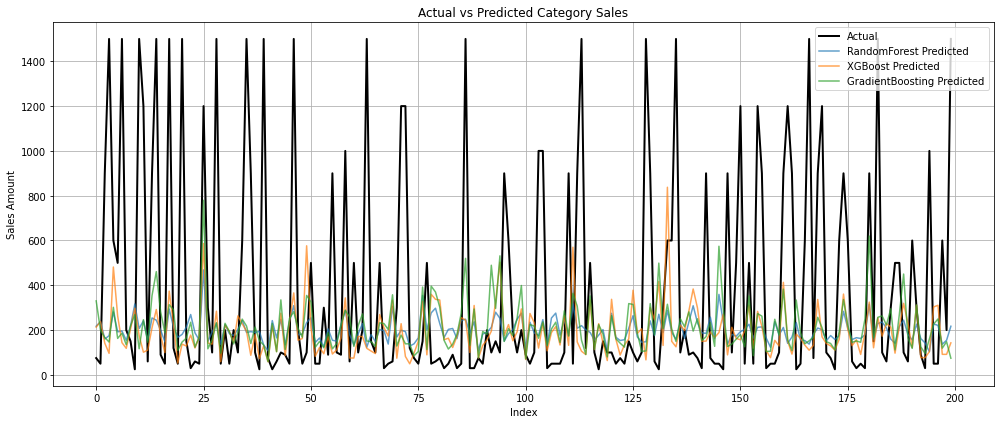

In [28]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_true.reset_index(drop=True), label='Actual', color='black', linewidth=2)

for name, (preds, _, _) in results.items():
    plt.plot(pd.Series(preds).reset_index(drop=True), label=f'{name} Predicted', alpha=0.7)

plt.legend()
plt.title("Actual vs Predicted Category Sales")
plt.xlabel("Index")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

### Inference with best model

In [29]:
# Example prediction input
sample_input = pd.DataFrame([{
    'Age': 30,
    'Gender': 'Male',
    'Product Category': 'Clothing',
    'Day': 10,
    'Month': 5,
    'Weekday': pd.Timestamp('2025-05-10').weekday(),
    'isWeekend': int(pd.Timestamp('2025-05-10').weekday() in [5, 6]),
    'isAfter25': int(3 > 25)
}])

# Load model and predict
model = joblib.load('./models/full_transaction_model.pkl')
predicted_log = model.predict(sample_input)
predicted_sales = np.expm1(predicted_log[0])
print("Forecasted Sales:", round(predicted_sales, 2))


Forecasted Sales: 221.83


**Conclusion:** <br>
Three multivariate models(RandomForest, GradientBoost, XGBoost) were fit and compared. The model doesn't seems to fit so well. All these models are hypertuned with grid search and the best model is saved. However, the models appear to be underfitting. It is also to under that the limited data sample of only a year is also a reason for models to find hard learning patterns.
<br>

We proceed with the best fit, which is GradientBoost in our case with least MAE.

**Possible Enhancements:** <br>
- Hypertune more with hihger estimators and higher learning rates
- Try wider architectures like MLP
- Experiment with Prophet model by Meta
- Combine with LSTM